# Lancaster County, PA Investigation

In order to see what kinds of post-solution analyses would be useful/interesting for the Beta release, this notebook looks at results of finding optimal solutions to the NLP for Lancaster county.

We will combine the results from both cost-minimization-objective and load-maximization-objective, look at the results' curves, and then plot the results on a map.

### Data Sources
- P6Beta_v3_LRSegs_081516_Albers.shp: a shapefile with land-river-segment geographies throughout the Bay watershed (*Gopal shared this with me via email on 2018/12/11*)
- lancasterPA_solutionlist_20190102.txt: a list of optimization solution .csv files to read (*generated these results myself on Cloudfish on 2019/01/02*) 

### Changes
- 2019/01/03: Duplicated this notebook from 1.0-dek-calvertMD_investigation

### Table of Contents
1. [Load Data](#load_data)
    1. [load shapefiles](#load_shapefiles)
    2. [load solution data](#load_solution_data)
2. [Make Solution "Objective-Constraint" Figures](#make_solution_objective-constraint_figures)
3. [Merge Geo data with Solution data](#merge_geo_data_with_solution_data)
4. [Prepare data for solution "Variable-Values" visualizations](#prepare_data_for_solution_variable-values_visualizations)
    1. [Get data for a single constraint level](#get_data_for_a_single_constraint_level)
    2. [Get data for a single BMP](#get_data_for_a_single_bmp)
5. [Map the results](#map_the_results)

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product

import re

import matplotlib.pyplot as plt
import matplotlib.cm

import geopandas as gpd

<a id='load_data'></a>
# 1. Load Data

<a id='load_shapefiles'></a>
### 1a. load shapefiles

In [7]:
# Get shape geometries of all the LRsegs
lrsegshapefiledir = '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/bayota/data/shapefiles/P6Beta_v3_LRSegs_081516_Albers'
fp = os.path.join(lrsegshapefiledir, 'P6Beta_v3_LRSegs_081516_Albers.shp')

lrsegs_geometries_df = gpd.read_file(fp)
display(lrsegs_geometries_df.head(2))

# Get the shape geometries of this county
county_name = 'Lancaster'
state_abbrev = 'PA'

Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater MajMin  \
0     Z     Z    9999  9999     0  ZZ0_9999_9999          N     ZZ   
1     Z     Z    9999  9999     0  ZZ0_9999_9999          N     ZZ   

                                        Region  \
0  Regions Outside of Chesapeake Bay Watershed   
1  Regions Outside of Chesapeake Bay Watershed   

                               Watershed  \
0  Land Segment Only-No River Simulation   
1  Land Segment Only-No River Simulation   

                         ...                          ST  CNTYNAME CBW  \
0                        ...                          NY  ALLEGANY   N   
1                        ...                          NY    BROOME   N   

  FIPS_NHL PRECIP  MEANPRECIP            LndRvrSeg          Acres  HGMR  \
0   N36003      N        1021  N36003ZZ0_9999_9999  608092.605660  None   
1   N36007      N        1055  N36007ZZ0_9999_9999   51399.259219  None   

                                            geometry  
0  POLYGON ((1457905.657400004 2307419.286199999,...  
1  POLYGON ((1675276.761900002 2314848.455699998,...  

[2 rows x 26 columns]

In [11]:
# Create county-level geodataframe
# Dissolve LRsegs into county-level geometries
counties_geometries_df = lrsegs_geometries_df.loc[:, ['ST', 'CNTYNAME', 'geometry']].dissolve(by=['ST', 'CNTYNAME']).reset_index()

# Change the projection of the GeoDataframe to represent the lat/lon
lrsegs_geometries_df = lrsegs_geometries_df.to_crs({'init': 'epsg:4326'}) 
counties_geometries_df = counties_geometries_df.to_crs({'init': 'epsg:4326'}) 
display(lrsegs_geometries_df.head(2))
display(counties_geometries_df.head(2))

Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater MajMin  \
0     Z     Z    9999  9999     0  ZZ0_9999_9999          N     ZZ   
1     Z     Z    9999  9999     0  ZZ0_9999_9999          N     ZZ   

                                        Region  \
0  Regions Outside of Chesapeake Bay Watershed   
1  Regions Outside of Chesapeake Bay Watershed   

                               Watershed  \
0  Land Segment Only-No River Simulation   
1  Land Segment Only-No River Simulation   

                         ...                          ST  CNTYNAME CBW  \
0                        ...                          NY  ALLEGANY   N   
1                        ...                          NY    BROOME   N   

  FIPS_NHL PRECIP  MEANPRECIP            LndRvrSeg          Acres  HGMR  \
0   N36003      N        1021  N36003ZZ0_9999_9999  608092.605660  None   
1   N36007      N        1055  N36007ZZ0_9999_9999   51399.259219  None   

                                            geometry  
0  POLYGON ((-78.03826200042818 42.52151950023057...  
1  POLYGON ((-75.41842100089326 42.19503199978549...  

[2 rows x 26 columns]

ST          CNTYNAME                                           geometry
0  DC  DIST OF COLUMBIA  (POLYGON ((-77.02199829726413 38.8047115107170...
1  DE              KENT  POLYGON ((-75.52043900080832 38.85574200015411...

{'minx': -76.72162000020496,
 'miny': 39.72113099990304,
 'maxx': -75.87337500044895,
 'maxy': 40.31597100026103}

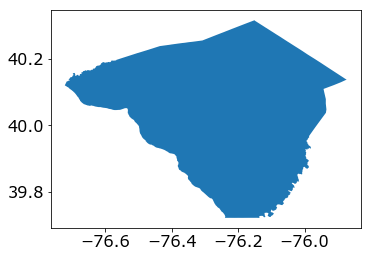

In [94]:
# Extract this particular county's geometry
mask = (counties_geometries_df['CNTYNAME'].str.lower() == county_name.lower()) & (counties_geometries_df['ST'].str.lower() == state_abbrev.lower())
whole_county_geometry_df = counties_geometries_df.loc[mask, :]
whole_county_geometry_df.plot()

county_bounds = whole_county_geometry_df['geometry'].bounds.reset_index().loc[0, ['minx', 'miny', 'maxx', 'maxy']].to_dict()
display(county_bounds)

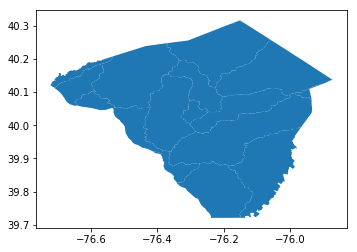

In [15]:
# Extract subset of lrsegs located within the county
mask = (lrsegs_geometries_df['CNTYNAME'].str.lower() == county_name.lower()) & (lrsegs_geometries_df['ST'].str.lower() == state_abbrev.lower())
county_lrsegs_geometries_df = lrsegs_geometries_df.loc[mask, :]
county_lrsegs_geometries_df.plot()

<a id='load_solution_data'></a>
### 1b. Load solution data

In [17]:
output_dir = '/Users/Danny/bayota_ws_0.0.1/output/general/lancasterPA_20190102'
namelistfile = 'lancasterPA_solutionlist_20190102.txt'
filelist = os.path.join(output_dir, namelistfile)

with open(os.path.join(output_dir, namelistfile)) as f:
    content = f.readlines()
filelist = [os.path.join(output_dir, x.strip()) for x in content]

In [18]:
# Add a column with file names
dlist = []
for f in filelist:
    tmpdf = pd.read_csv(f)
    tmpdf['solutionname'] = os.path.basename(f)

    #     (pd.DataFrame.assign)(df, solutionname=os.path.basename(filename))

    dlist.append(tmpdf)
df = pd.concat(dlist, ignore_index=True)
display(df.head(2))

df = df.loc[df['acres'] >= 0.5, :]

# Add a column with unique variable (x) names
df['x'] = list(zip(df.bmpshortname,
                   df.landriversegment,
                   df.loadsource,
                   df.totalannualizedcostperunit))

df = df.reset_index()
display(df.head(2))

/Users/Danny/anaconda3/envs/bayota36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Unnamed: 0      acres bmpshortname  feasible     landriversegment  \
0           0  42.640804   LowResTill      True  N42071SL9_2430_2490   
1           1  37.912683   LowResTill      True  N42071SL9_2430_2490   

  loadsource  percent_reduction_minimum  solution_objective  \
0        som                        1.0            0.000116   
1        sch                        1.0            0.000116   

                                        solutionname  \
0  solutiondf_modelinstance_costmin_total_percent...   
1  solutiondf_modelinstance_costmin_total_percent...   

   totalannualizedcostperunit  totalcostupperbound  totalinstancecost  
0                         0.0                  NaN                0.0  
1                         0.0                  NaN                0.0

index  Unnamed: 0      acres bmpshortname  feasible     landriversegment  \
0      0           0  42.640804   LowResTill      True  N42071SL9_2430_2490   
1      1           1  37.912683   LowResTill      True  N42071SL9_2430_2490   

  loadsource  percent_reduction_minimum  solution_objective  \
0        som                        1.0            0.000116   
1        sch                        1.0            0.000116   

                                        solutionname  \
0  solutiondf_modelinstance_costmin_total_percent...   
1  solutiondf_modelinstance_costmin_total_percent...   

   totalannualizedcostperunit  totalcostupperbound  totalinstancecost  \
0                         0.0                  NaN                0.0   
1                         0.0                  NaN                0.0   

                                             x  
0  (LowResTill, N42071SL9_2430_2490, som, 0.0)  
1  (LowResTill, N42071SL9_2430_2490, sch, 0.0)

In [19]:
df['objective_cost'] = df['solution_objective']
df['objective_loadreduction'] = df['solution_objective']

df.loc[np.isnan(df.totalcostupperbound), 'objective_loadreduction'] = np.nan
df.loc[np.isnan(df.percent_reduction_minimum), 'objective_cost'] = np.nan
display(df.head(2))
display(df.tail(2))

index  Unnamed: 0      acres bmpshortname  feasible     landriversegment  \
0      0           0  42.640804   LowResTill      True  N42071SL9_2430_2490   
1      1           1  37.912683   LowResTill      True  N42071SL9_2430_2490   

  loadsource  percent_reduction_minimum  solution_objective  \
0        som                        1.0            0.000116   
1        sch                        1.0            0.000116   

                                        solutionname  \
0  solutiondf_modelinstance_costmin_total_percent...   
1  solutiondf_modelinstance_costmin_total_percent...   

   totalannualizedcostperunit  totalcostupperbound  totalinstancecost  \
0                         0.0                  NaN                0.0   
1                         0.0                  NaN                0.0   

                                             x  objective_cost  \
0  (LowResTill, N42071SL9_2430_2490, som, 0.0)        0.000116   
1  (LowResTill, N42071SL9_2430_2490, sch, 0.0)        0.000116   

   objective_loadreduction  
0                      NaN  
1                      NaN

index  Unnamed: 0      acres bmpshortname  feasible  \
23115  568442        9005  20.283937       HRTill      True   
23116  568443        9006  41.634438       HRTill      True   

          landriversegment loadsource  percent_reduction_minimum  \
23115  N42071SL9_2700_2720        scl                        NaN   
23116  N42071SL9_2700_2720        sch                        NaN   

       solution_objective                                       solutionname  \
23115            21.66513  solutiondf_modelinstance_loadreductionmax_Lanc...   
23116            21.66513  solutiondf_modelinstance_loadreductionmax_Lanc...   

       totalannualizedcostperunit  totalcostupperbound  totalinstancecost  \
23115                         0.0            4000000.0                0.0   
23116                         0.0            4000000.0                0.0   

                                             x  objective_cost  \
23115  (HRTill, N42071SL9_2700_2720, scl, 0.0)             NaN   
23116  (HRTill, N42071SL9_2700_2720, sch, 0.0)             NaN   

       objective_loadreduction  
23115                 21.66513  
23116                 21.66513

In [20]:
# Keep one row for each optimization trial, since we're just looking at objective and constraint values (rather than variable values)
df_single_row_for_each_solution = df.drop_duplicates(subset=['solutionname'])
display(df_single_row_for_each_solution.head(2))

index  Unnamed: 0      acres bmpshortname  feasible     landriversegment  \
0        0           0  42.640804   LowResTill      True  N42071SL9_2430_2490   
634    650           0  43.792386   LowResTill      True  N42071SL9_2310_2430   

    loadsource  percent_reduction_minimum  solution_objective  \
0          som                        1.0            0.000116   
634        gom                        2.0            0.000017   

                                          solutionname  \
0    solutiondf_modelinstance_costmin_total_percent...   
634  solutiondf_modelinstance_costmin_total_percent...   

     totalannualizedcostperunit  totalcostupperbound  totalinstancecost  \
0                           0.0                  NaN                0.0   
634                         0.0                  NaN                0.0   

                                               x  objective_cost  \
0    (LowResTill, N42071SL9_2430_2490, som, 0.0)        0.000116   
634  (LowResTill, N42071SL9_2310_2430, gom, 0.0)        0.000017   

     objective_loadreduction  
0                        NaN  
634                      NaN

<a id='make_solution_objective-constraint_figures'></a>
# 2. Make Solution "Objective-Constraint" Figures

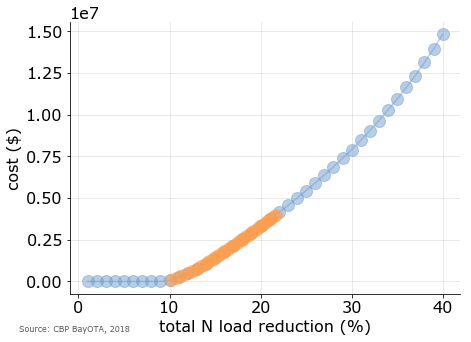

In [21]:
# from bayota_settings.config_script import get_graphics_dir
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['MS Reference Sans Serif']
rcParams['font.weight'] = 'normal'
rcParams['font.size'] = 16

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(7, 5))

# ------- Plot 1 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'percent_reduction_minimum'
yvar = 'objective_cost'
ax.plot(df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        color=[114/255, 158/255, 206/255],
        linestyle='-',
        markersize=12,
        marker='o',
        alpha=0.5)

# ------- Plot 2 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'objective_loadreduction'
yvar = 'totalcostupperbound'
ax.plot(df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        #color=[255/255, 127/255, 14/255],
        color=[255/255, 158/255, 74/255],
        linestyle='-',
        markersize=12,
        marker='o',
        alpha=0.5)

ax.grid(color=[200/255, 200/255, 200/255],
            alpha=0.4, linestyle='-', linewidth=1)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

ax.set_xlabel('total N load reduction (%)')
ax.set_ylabel('cost ($)')

# add a title
ax.set_title('', fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.04, .05), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8, color='#555555')

# Save the graphic
fig.savefig("pareto_lancasterPA_20190103.png",
            bbox_inches='tight', dpi=300)
# fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
#             bbox_inches='tight', dpi=300)

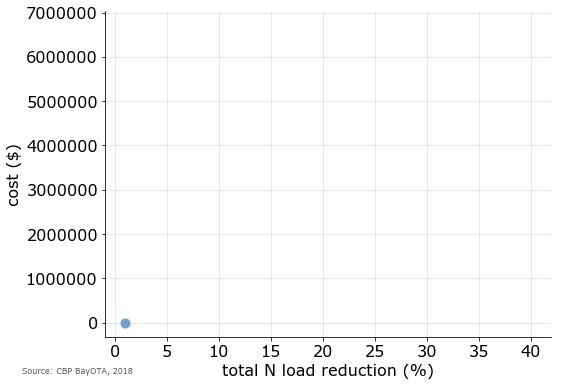

In [22]:
# from bayota_settings.config_script import get_graphics_dir
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['MS Reference Sans Serif']
rcParams['font.weight'] = 'normal'
rcParams['font.size'] = 16

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# ------- Plot 1 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'percent_reduction_minimum'
yvar = 'objective_cost'
ax.plot(#df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        df_single_row_for_each_solution.loc[df_single_row_for_each_solution[xvar]==1,:][xvar], 
        df_single_row_for_each_solution.loc[df_single_row_for_each_solution[xvar]==1,:][yvar],
        color=[114/255, 158/255, 206/255],
        linestyle='-',
        markersize=9,
        marker='o')

ax.set_xlim(-0.9500000000000002, 41.95)
ax.set_ylim(-334831.9665814999, 7031471.298664903)

# print(ax.get_xlim())
# print(ax.get_ylim())

ax.grid(color=[200/255, 200/255, 200/255],
            alpha=0.4, linestyle='-', linewidth=1)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

ax.set_xlabel('total N load reduction (%)')
ax.set_ylabel('cost ($)')
ax.set_title('', fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.04, .05), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8, color='#555555')

# Save the graphic
fig.savefig("costvsload_lancasterPA_1pt_20190103.png",
            bbox_inches='tight', dpi=300)
# fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
#             bbox_inches='tight', dpi=300)

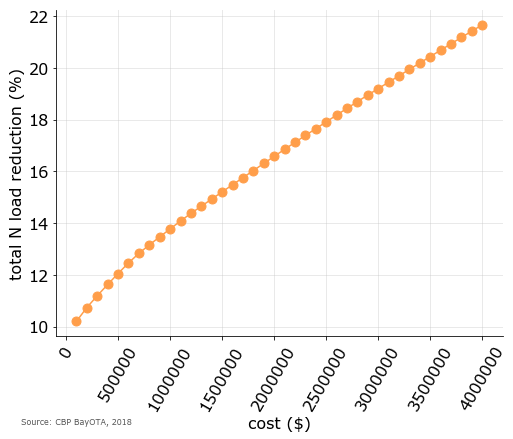

In [23]:
# from bayota_settings.config_script import get_graphics_dir
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['MS Reference Sans Serif']
rcParams['font.weight'] = 'normal'
rcParams['font.size'] = 16

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))

# ------- Plot 2 -------
# set a variable that will call whatever column we want to visualise on the map
xvar = 'totalcostupperbound'
yvar = 'objective_loadreduction'
ax.plot(df_single_row_for_each_solution[xvar], df_single_row_for_each_solution[yvar],
        color=[255/255, 158/255, 74/255],
        linestyle='-',
        markersize=9,
        marker='o')

ax.grid(color=[200/255, 200/255, 200/255],
            alpha=0.4, linestyle='-', linewidth=1)

# Hide the right and top spines
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.xticks(rotation=60)
ax.set_xlabel('cost ($)')
ax.set_ylabel('total N load reduction (%)')
ax.set_title('', fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.04, .05), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=8, color='#555555')

# Save the graphic
fig.savefig("loadvscost_lancasterPA_20190103.png",
            bbox_inches='tight', dpi=300)
# fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
#             bbox_inches='tight', dpi=300)

<a id='merge_geo_data_with_solution_data'></a>
# 3. Merge Geo data with Solution data

In [24]:
merged = county_lrsegs_geometries_df.set_index('LndRvrSeg').join(df.set_index('landriversegment'))
display(merged.shape)
display(merged.head(2))

(23119, 40)

Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater  \
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   

                    MajMin                    Region                Watershed  \
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   

                              ...           loadsource  \
N42071SL1_2190_2350           ...                  som   
N42071SL1_2190_2350           ...                  sch   

                    percent_reduction_minimum solution_objective  \
N42071SL1_2190_2350                       1.0           0.000116   
N42071SL1_2190_2350                       1.0           0.000116   

                                                          solutionname  \
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   

                    totalannualizedcostperunit  totalcostupperbound  \
N42071SL1_2190_2350                        0.0                  NaN   
N42071SL1_2190_2350                        0.0                  NaN   

                    totalinstancecost  \
N42071SL1_2190_2350               0.0   
N42071SL1_2190_2350               0.0   

                                                               x  \
N42071SL1_2190_2350  (LowResTill, N42071SL1_2190_2350, som, 0.0)   
N42071SL1_2190_2350  (LowResTill, N42071SL1_2190_2350, sch, 0.0)   

                    objective_cost objective_loadreduction  
N42071SL1_2190_2350       0.000116                     NaN  
N42071SL1_2190_2350       0.000116                     NaN  

[2 rows x 40 columns]

<a id='prepare_data_for_solution_variable-values_visualizations'></a>
# 4. Prepare data for solution "Variable-Values" visualizations

In [25]:
merged_loadredmax = merged.loc[np.isnan(merged['percent_reduction_minimum']), :]
merged_costmin = merged.loc[np.isnan(merged['totalcostupperbound']), :]
merged_loadredmax.head(2)
merged_costmin.head(2)

Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater  \
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   

                    MajMin                    Region                Watershed  \
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   

                              ...           loadsource  \
N42071SL1_2190_2350           ...                  som   
N42071SL1_2190_2350           ...                  sch   

                    percent_reduction_minimum solution_objective  \
N42071SL1_2190_2350                       1.0           0.000116   
N42071SL1_2190_2350                       1.0           0.000116   

                                                          solutionname  \
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   

                    totalannualizedcostperunit  totalcostupperbound  \
N42071SL1_2190_2350                        0.0                  NaN   
N42071SL1_2190_2350                        0.0                  NaN   

                    totalinstancecost  \
N42071SL1_2190_2350               0.0   
N42071SL1_2190_2350               0.0   

                                                               x  \
N42071SL1_2190_2350  (LowResTill, N42071SL1_2190_2350, som, 0.0)   
N42071SL1_2190_2350  (LowResTill, N42071SL1_2190_2350, sch, 0.0)   

                    objective_cost objective_loadreduction  
N42071SL1_2190_2350       0.000116                     NaN  
N42071SL1_2190_2350       0.000116                     NaN  

[2 rows x 40 columns]

percent_reduction_minimum  bmpshortname         acres
0                        1.0  ConserveTill  49627.958761
1                        1.0        HRTill  49892.517203

bmpshortname               AgStormEff  BarnRunoffCont  ConPlan  ConserveTill  \
percent_reduction_minimum                                                      
1.0                               NaN             NaN      NaN  49627.958761   
2.0                               NaN             NaN      NaN  49500.683961   

bmpshortname               CoverCropTradRED        HRTill  IncorpLowEarly  \
percent_reduction_minimum                                                   
1.0                                     NaN  49892.517203             NaN   
2.0                                     NaN  49774.021854             NaN   

bmpshortname                 LowResTill  UrbanNMMDDIY   UrbanNMPlan  \
percent_reduction_minimum                                             
1.0                        49092.851272  19532.327314  19562.329273   
2.0                        48926.972304  19533.584364  19575.433557   

bmpshortname               UrbanNMPlanHR  UrbanNMPlanLR  WaterContStruc  
percent_reduction_minimum                                                
1.0                         19599.176756   19552.314079             NaN  
2.0                         19625.068177   19561.582028             NaN

(40, 13)

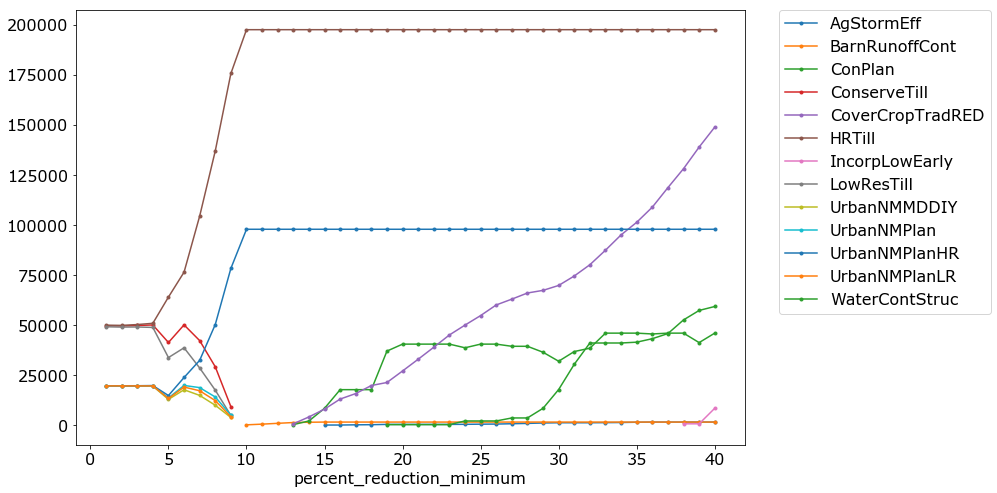

In [26]:
from pandas.plotting import parallel_coordinates

grouped = merged_costmin.groupby(['percent_reduction_minimum', 'bmpshortname'])
merged_costmin_bmptotals = grouped[['acres']].sum()

merged_costmin_bmptotals.reset_index(level=['percent_reduction_minimum', 'bmpshortname'], inplace=True)
merged_costmin_bmptotals.sort_values(by='percent_reduction_minimum')
display(merged_costmin_bmptotals.head(2))

bmptotals_pivoted = merged_costmin_bmptotals.pivot(index='percent_reduction_minimum', columns='bmpshortname', values='acres')
display(bmptotals_pivoted.head(2))
display(bmptotals_pivoted.shape)

fig, ax = plt.subplots(1, figsize=(12, 8))
bmptotals_pivoted.plot(ax=ax, marker='.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
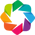

In [27]:
import holoviews as hv
hv.extension('bokeh')

In [28]:
# Basic plot using HoloView
scatter = hv.Scatter(merged_costmin, 'percent_reduction_minimum', 'solution_objective')
scatter

:Scatter   [percent_reduction_minimum]   (solution_objective)

In [29]:
grouped = merged_costmin.groupby(['percent_reduction_minimum', 'bmpshortname'])
merged_costmin_bmptotals = grouped[['acres']].sum()

merged_costmin_bmptotals.reset_index(level=['percent_reduction_minimum', 'bmpshortname'], inplace=True)
merged_costmin_bmptotals.sort_values(by='percent_reduction_minimum')
display(merged_costmin_bmptotals.head(2))

percent_reduction_minimum  bmpshortname         acres
0                        1.0  ConserveTill  49627.958761
1                        1.0        HRTill  49892.517203

In [30]:
coords = {b: hv.Scatter(merged_costmin_bmptotals.loc[merged_costmin_bmptotals['bmpshortname']==b, :],
                        'percent_reduction_minimum', 'acres')
          for b in list(merged_costmin_bmptotals['bmpshortname'])}

hv.HoloMap(coords, kdims='BMP')

:HoloMap   [BMP]
   :Scatter   [percent_reduction_minimum]   (acres)

<a id='get_data_for_a_single_constraint_level'></a>
### 4a. Get data for a single constraint level

In [31]:
this_constraint_value = 30

single_constraint_level_data = merged_costmin.loc[merged_costmin['percent_reduction_minimum']==this_constraint_value, :]
display(single_constraint_level_data.head(2))
display(single_constraint_level_data.shape)

Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater  \
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   

                    MajMin                    Region                Watershed  \
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   

                              ...           loadsource  \
N42071SL1_2190_2350           ...                  pas   
N42071SL1_2190_2350           ...                  fnp   

                    percent_reduction_minimum solution_objective  \
N42071SL1_2190_2350                      30.0       7.910541e+06   
N42071SL1_2190_2350                      30.0       7.910541e+06   

                                                          solutionname  \
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   

                    totalannualizedcostperunit  totalcostupperbound  \
N42071SL1_2190_2350                       1.94                  NaN   
N42071SL1_2190_2350                    1638.65                  NaN   

                    totalinstancecost  \
N42071SL1_2190_2350       6308.263392   
N42071SL1_2190_2350     131983.087265   

                                                                   x  \
N42071SL1_2190_2350        (ConPlan, N42071SL1_2190_2350, pas, 1.94)   
N42071SL1_2190_2350  (AgStormEff, N42071SL1_2190_2350, fnp, 1638.65)   

                    objective_cost objective_loadreduction  
N42071SL1_2190_2350   7.910541e+06                     NaN  
N42071SL1_2190_2350   7.910541e+06                     NaN  

[2 rows x 40 columns]

(277, 40)

<a id='get_data_for_a_single_bmp'></a>
### 4b. Get data for a single BMP

In [32]:
thismapdata = single_constraint_level_data.loc[single_constraint_level_data['bmpshortname'] == 'UrbanNMPlanHR', :]
display(thismapdata.head(2))
display(thismapdata.shape)


Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater  \
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   

                    MajMin                    Region                Watershed  \
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   
N42071SL1_2190_2350     SL  Chesapeake Bay Watershed  Susquehanna River Basin   

                              ...           loadsource  \
N42071SL1_2190_2350           ...                  ntg   
N42071SL1_2190_2350           ...                  mcn   

                    percent_reduction_minimum solution_objective  \
N42071SL1_2190_2350                      30.0       7.910541e+06   
N42071SL1_2190_2350                      30.0       7.910541e+06   

                                                          solutionname  \
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   
N42071SL1_2190_2350  solutiondf_modelinstance_costmin_total_percent...   

                    totalannualizedcostperunit  totalcostupperbound  \
N42071SL1_2190_2350                        0.0                  NaN   
N42071SL1_2190_2350                        0.0                  NaN   

                    totalinstancecost  \
N42071SL1_2190_2350               0.0   
N42071SL1_2190_2350               0.0   

                                                                  x  \
N42071SL1_2190_2350  (UrbanNMPlanHR, N42071SL1_2190_2350, ntg, 0.0)   
N42071SL1_2190_2350  (UrbanNMPlanHR, N42071SL1_2190_2350, mcn, 0.0)   

                    objective_cost objective_loadreduction  
N42071SL1_2190_2350   7.910541e+06                     NaN  
N42071SL1_2190_2350   7.910541e+06                     NaN  

[2 rows x 40 columns]

(63, 40)

In [33]:
thismapdata.columns

Index(['Major', 'Minor', 'UniqID', 'DSID', 'Flow', 'RiverSeg', 'TidalWater',
       'MajMin', 'Region', 'Watershed', 'MajBas', 'MinBas', 'RiverSimu',
       'RiverName', 'CBSEG_92', 'FIPS', 'ST', 'CNTYNAME', 'CBW', 'FIPS_NHL',
       'PRECIP', 'MEANPRECIP', 'Acres', 'HGMR', 'geometry', 'index',
       'Unnamed: 0', 'acres', 'bmpshortname', 'feasible', 'loadsource',
       'percent_reduction_minimum', 'solution_objective', 'solutionname',
       'totalannualizedcostperunit', 'totalcostupperbound',
       'totalinstancecost', 'x', 'objective_cost', 'objective_loadreduction'],
      dtype='object')

In [51]:
grouped = thismapdata.groupby([thismapdata.index.get_level_values(0)])
mapdata_sum = grouped[['acres']].sum()
display(mapdata_sum.head(2))
display(mapdata_sum.shape)

mapdata_merged = county_lrsegs_geometries_df.set_index('LndRvrSeg').join(mapdata_sum)
display(mapdata_merged.shape)
display(mapdata_merged.head(2))

acres
N42071SL1_2190_2350  13680.463514
N42071SL1_2390_2420   7145.915849

(14, 1)

(16, 26)

Major Minor  UniqID  DSID  Flow       RiverSeg TidalWater  \
LndRvrSeg                                                                       
N42071ZZ0_9999_9999     Z     Z    9999  9999     0  ZZ0_9999_9999          N   
N42071SL1_2190_2350     S     L    2190  2350     1  SL1_2190_2350          N   

                    MajMin                                       Region  \
LndRvrSeg                                                                 
N42071ZZ0_9999_9999     ZZ  Regions Outside of Chesapeake Bay Watershed   
N42071SL1_2190_2350     SL                     Chesapeake Bay Watershed   

                                                 Watershed      ...       ST  \
LndRvrSeg                                                       ...            
N42071ZZ0_9999_9999  Land Segment Only-No River Simulation      ...       PA   
N42071SL1_2190_2350                Susquehanna River Basin      ...       PA   

                      CNTYNAME CBW FIPS_NHL PRECIP  MEANPRECIP         Acres  \
LndRvrSeg                                                                      
N42071ZZ0_9999_9999  LANCASTER   N   N42071      N        1118   2114.925980   
N42071SL1_2190_2350  LANCASTER   Y   N42071      N        1118  70566.648505   

                     HGMR                                           geometry  \
LndRvrSeg                                                                      
N42071ZZ0_9999_9999  None  (POLYGON ((-75.9379980003888 40.11113899979433...   
N42071SL1_2190_2350    ML  POLYGON ((-76.14017168526622 40.30855533534253...   

                            acres  
LndRvrSeg                          
N42071ZZ0_9999_9999           NaN  
N42071SL1_2190_2350  13680.463514  

[2 rows x 26 columns]

In [52]:
mapdata_merged.columns

Index(['Major', 'Minor', 'UniqID', 'DSID', 'Flow', 'RiverSeg', 'TidalWater',
       'MajMin', 'Region', 'Watershed', 'MajBas', 'MinBas', 'RiverSimu',
       'RiverName', 'CBSEG_92', 'FIPS', 'ST', 'CNTYNAME', 'CBW', 'FIPS_NHL',
       'PRECIP', 'MEANPRECIP', 'Acres', 'HGMR', 'geometry', 'acres'],
      dtype='object')

<a id='map_the_results'></a>
# 5. Map the results

Text(0.1, 0.08, 'Source: CBP BayOTA, 2018')

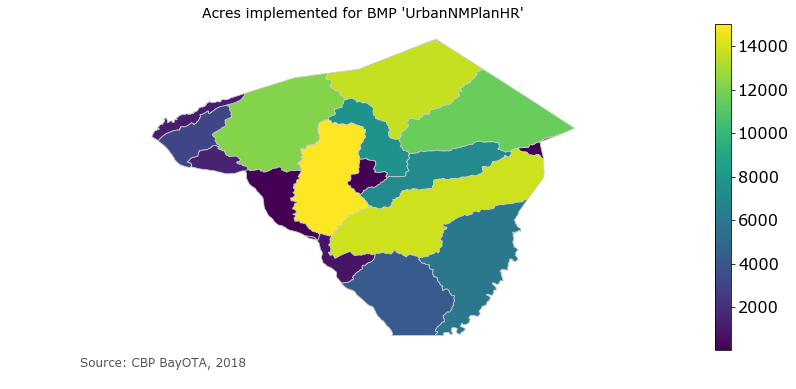

In [53]:
# from bayota_settings.config_script import get_graphics_dir

# set a variable that will call whatever column we want to visualise on the map
variable = 'acres'
# set the range for the choropleth
vmin, vmax = 0, mapdata_merged[variable].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 6))
lims = plt.axis('equal')

mapdata_merged.plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# other colormap ideas: Blues, viridis, cividis, plasma

# remove the axis
ax.axis('off')

# add a title
# titlestr = "Total cost for a 10% Total Nitrogen Reduction (from 2010 'No-action')"
titlestr = "Acres implemented for BMP 'UrbanNMPlanHR'"
ax.set_title(titlestr, fontdict={'fontsize': '14', 'fontweight' : '3'})

# create an annotation for the data source
ax.annotate("Source: CBP BayOTA, 2018",
            xy=(0.1, .08), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=12, color='#555555')

# Save the map
# fig.savefig("map_export_new.png",
#             bbox_inches='tight', dpi=300)
## fig.savefig(os.path.join(get_graphics_dir(), "map_export_new.png"),
##             bbox_inches='tight', dpi=300)

In [36]:
def county_bmp_gdf(this_constraint_value, this_bmpshortname):
    # Get data for a single constraint level
    single_constraint_level_data = merged_costmin.loc[merged_costmin['percent_reduction_minimum']==this_constraint_value, :]
    # Get data for a single BMP
    thismapdata = single_constraint_level_data.loc[single_constraint_level_data['bmpshortname'] == this_bmpshortname, :]
    
    grouped = thismapdata.groupby([thismapdata.index.get_level_values(0)])
    mapdata_sum = grouped[['acres']].sum()
    
    mapdata_merged = county_lrsegs_geometries_df.set_index('LndRvrSeg').join(mapdata_sum)
    
    mapdata_merged.reset_index(level='LndRvrSeg', inplace=True)
    
    return mapdata_merged

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
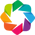

In [37]:
import geoviews as gv
gv.extension('bokeh')

In [38]:
display(whole_county_geometry_df.head(5))

ST   CNTYNAME                                           geometry
70  PA  LANCASTER  POLYGON ((-76.15295520567688 39.72145701755532...

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
county_bmp_gdf(30, 'UrbanNMPlanHR').loc[:, ['LndRvrSeg', 'acres', 'geometry']].head()

LndRvrSeg         acres  \
0  N42071ZZ0_9999_9999           NaN   
1  N42071SL1_2190_2350  13680.463514   
2  N42071SL2_2200_2350  11606.464272   
3  N42071SL2_2300_2520  12251.430587   
4  N42071SL9_2310_2430   1155.483042   

                                            geometry  
0  (POLYGON ((-75.9379980003888 40.11113899979433...  
1  POLYGON ((-76.14017168526622 40.30855533534253...  
2  POLYGON ((-75.87337500044895 40.13710700021321...  
3  POLYGON ((-76.33480056354595 40.19540193559963...  
4  POLYGON ((-76.57184566507824 40.1833893004711,...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
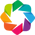

In [55]:
gv.extension('matplotlib', 'bokeh')

:Polygons   [Longitude,Latitude]   (LndRvrSeg,acres)
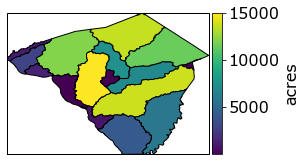

In [56]:
# Convert whole-county geometry into a Boundary Shape
# county_boundaries = gv.Shape(whole_county_geometry_df.geometry.iloc[0])

plot_opts = dict(tools=['hover'], width=550, height=700, color_index='acres',
                 colorbar=True, toolbar='above', xaxis=None, yaxis=None)
# f, ax = plt.subplots(1, figsize=(9, 9))
thismapdf = county_bmp_gdf(15, 'UrbanNMPlanHR').loc[:, ['LndRvrSeg', 'acres', 'geometry']]
gvfig = gv.Polygons(thismapdf, vdims=['LndRvrSeg','acres']).opts(plot=plot_opts)
gvfig

# display(type(gvfig.))

# Setup figure and axis
# f, ax = plt.subplots(1, figsize=(9, 9))
# Add hexagon layer that displays count of points in each polygon
# hb = ax.hexbin(centroids_x, centroids_y, gridsize=20, alpha=0.8, cmap='BuPu')
# Add a colorbar (optional)
# plt.colorbar(hb)
# bkfig = hv.render(gvfig)
# bkfig = hv.renderers('bokeh')

# renderer = hv.renderer('bokeh')
# display(type(renderer))
# bkplot = renderer.get_plot(gvfig).state
# display(type(bkplot))

# renderer.hold()

# from bokeh.io import output_file, show
# from bokeh.plotting import figure

# p = figure(title="", match_aspect=True,
#            tools="wheel_zoom,reset", background_fill_color='#440154')
# bkplot.grid.visible = False

# r, bins = bkplot.hexbin(np.array(centroids_x), np.array(centroids_y),
#                         size=0.05, hover_color="pink", hover_alpha=0.8)
# show(p)

In [57]:
xtemp = np.array([3, 2, 5, 3])
print(xtemp)
x2 = np.repeat(xtemp, xtemp.astype(int))
print(x2)


[3 2 5 3]
[3 3 3 2 2 5 5 5 5 5 3 3 3]


In [77]:
thismapdf = county_bmp_gdf(38, 'UrbanNMPlanHR').loc[:, ['LndRvrSeg', 'acres', 'geometry']].head(3)
thismapdf.dropna(axis='index', how='any', inplace=True)
display(thismapdf.head(10))

LndRvrSeg         acres  \
1  N42071SL1_2190_2350  13680.463515   
2  N42071SL2_2200_2350  11606.464272   

                                            geometry  
1  POLYGON ((-76.14017168526622 40.30855533534253...  
2  POLYGON ((-75.87337500044895 40.13710700021321...

In [78]:
newdf = pd.DataFrame(np.repeat(thismapdf.values, np.array(thismapdf['acres']).astype(int), axis=0))
newdf.columns = thismapdf.columns
display(newdf.head(15))
display(newdf.shape)

LndRvrSeg    acres  \
0   N42071SL1_2190_2350  13680.5   
1   N42071SL1_2190_2350  13680.5   
2   N42071SL1_2190_2350  13680.5   
3   N42071SL1_2190_2350  13680.5   
4   N42071SL1_2190_2350  13680.5   
5   N42071SL1_2190_2350  13680.5   
6   N42071SL1_2190_2350  13680.5   
7   N42071SL1_2190_2350  13680.5   
8   N42071SL1_2190_2350  13680.5   
9   N42071SL1_2190_2350  13680.5   
10  N42071SL1_2190_2350  13680.5   
11  N42071SL1_2190_2350  13680.5   
12  N42071SL1_2190_2350  13680.5   
13  N42071SL1_2190_2350  13680.5   
14  N42071SL1_2190_2350  13680.5   

                                             geometry  
0   POLYGON ((-76.14017168526622 40.30855533534253...  
1   POLYGON ((-76.14017168526622 40.30855533534253...  
2   POLYGON ((-76.14017168526622 40.30855533534253...  
3   POLYGON ((-76.14017168526622 40.30855533534253...  
4   POLYGON ((-76.14017168526622 40.30855533534253...  
5   POLYGON ((-76.14017168526622 40.30855533534253...  
6   POLYGON ((-76.14017168526622 40.30855533534253...  
7   POLYGON ((-76.14017168526622 40.30855533534253...  
8   POLYGON ((-76.14017168526622 40.30855533534253...  
9   POLYGON ((-76.14017168526622 40.30855533534253...  
10  POLYGON ((-76.14017168526622 40.30855533534253...  
11  POLYGON ((-76.14017168526622 40.30855533534253...  
12  POLYGON ((-76.14017168526622 40.30855533534253...  
13  POLYGON ((-76.14017168526622 40.30855533534253...  
14  POLYGON ((-76.14017168526622 40.30855533534253...

(25286, 3)

In [95]:
bmpselection = 'CoverCropTradRED'
constraint_level_selection = 30

thismapdf = county_bmp_gdf(constraint_level_selection, bmpselection).loc[:, ['LndRvrSeg', 'acres', 'geometry']]
thismapdf.dropna(axis='index', how='any', inplace=True)

npv = np.array(thismapdf['acres'])
thismapdf['centerx'] = thismapdf.apply(lambda x: x['geometry'].centroid.x, axis=1)
thismapdf['centery'] = thismapdf.apply(lambda x: x['geometry'].centroid.y, axis=1)

# Expand arrays so that point density is equal to 'acres' value
thismapdf_expanded = pd.DataFrame(np.repeat(thismapdf.values,
                                            np.array(thismapdf['acres']).astype(int),
                                            axis=0))
thismapdf_expanded.columns = thismapdf.columns
# np.repeat changed types to string, so change them back to numeric
thismapdf_expanded[['acres', 'centerx', 'centery']] = thismapdf_expanded[['acres', 'centerx', 'centery']].apply(pd.to_numeric)
display(thismapdf_expanded.head(2))

npx_expanded = np.repeat(np.array(thismapdf['centerx']), npv.astype(int))
npy_expanded = np.repeat(np.array(thismapdf['centery']), npv.astype(int))

import bokeh
from bokeh.io import output_file, show
from bokeh.transform import linear_cmap
from bokeh.plotting import figure, gmap
import bokeh.models as bkm
from bokeh.models import HoverTool, LogColorMapper, ColorBar, LogTicker, GeoJSONDataSource, LinearColorMapper, ColumnDataSource
from bokeh.util.hex import cartesian_to_axial
from bokeh.palettes import RdYlBu11 as palette

geo_source = GeoJSONDataSource(geojson=thismapdf.to_json())

gsource = ColumnDataSource(dict(x=np.array(thismapdf['centerx']),
                                y=np.array(thismapdf['centery']),
                                acres=np.array(thismapdf['acres']),
                                LndRvrSeg=thismapdf['LndRvrSeg']))

p = figure(title="" + bmpselection + "", match_aspect=True,
           toolbar_location="above",
           background_fill_color='white',
           x_range=(county_bounds['minx'], county_bounds['maxx']), y_range=(county_bounds['miny'], county_bounds['maxy']))
p.grid.visible = False

g1 = bkm.glyphs.Patches(xs='xs', ys='ys', fill_alpha=0.7, 
#           fill_color={'field': 'acres', 'transform': LinearColorMapper(palette=palette)},
          fill_color='grey',
          line_color='black', line_width=0.5)
g1_r = p.add_glyph(source_or_glyph=geo_source, glyph=g1)
g1_hover = bkm.HoverTool(renderers=[g1_r],
                         tooltips=[("lrseg", "@LndRvrSeg")])
g1_hover.point_policy = 'follow_mouse'
p.add_tools(g1_hover)

color_mapper = LinearColorMapper(palette="Viridis256", low=0, high=max(thismapdf['acres']))

g2 = bkm.glyphs.Hex(x="x", y="y",
      fill_color=linear_cmap('acres', 'Viridis256', 0, max(thismapdf['acres'])),
      size=30)
g2_r = p.add_glyph(source_or_glyph=gsource, glyph=g2)
g2_hover = bkm.HoverTool(renderers=[g2_r],
                         tooltips=[("acres implemented", "@acres"), 
                            ("(x,y)", "(@x, @y)"),
                            ("lrseg", "@LndRvrSeg")])
g2_hover.point_policy = 'follow_mouse'
p.add_tools(g2_hover)


color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')

# p.patches('xs', 'ys', fill_alpha=0.7, 
# #           fill_color={'field': 'acres', 'transform': LinearColorMapper(palette=palette)},
#           fill_color='grey',
#           line_color='black', line_width=0.5, source=geo_source)

# p.hex(x="x", y="y", source = gsource, 
#       fill_color=linear_cmap('acres', 'Viridis256', 0, max(thismapdf['acres'])),
#       size=20, hover_color="pink", hover_alpha=0.8)

# hover = HoverTool(tooltips=[("acres", "@acres"), 
#                             ("(x,y)", "(@x, @y)"),
#                             ("lrseg", "@LndRvrSeg")])
# hover.point_policy = 'follow_mouse'
# p.add_tools(hover)


show(p)
# output_file("testbokehsave_20181226.html")
# bokeh.io.save(p, filename='testbokehsave_20190103')

LndRvrSeg        acres  \
0  N42071SL1_2190_2350  1224.297348   
1  N42071SL1_2190_2350  1224.297348   

                                            geometry    centerx    centery  
0  POLYGON ((-76.14017168526622 40.30855533534253... -76.208278  40.226291  
1  POLYGON ((-76.14017168526622 40.30855533534253... -76.208278  40.226291

In [ ]:
display(thismapdf.head())
thismapdf.shape

In [ ]:
len([(cl, b) for (cl, b) in product(range(1, 41), set(merged_costmin_bmptotals['bmpshortname']))])

In [ ]:
plot_opts = dict(tools=['hover'], width=550, height=700, color_index='acres',
             colorbar=True, toolbar='above', xaxis=None, yaxis=None)

def map_entity(cl, bname):
    dataframe = county_bmp_gdf(cl, bname)
    if not dataframe.empty:
        return gv.Polygons(dataframe.loc[:, ['LndRvrSeg', 'acres', 'geometry']],
                                               vdims=['LndRvrSeg', 'acres']).opts(plot=plot_opts)
    else:
        return None

In [ ]:
maps = [(cl, b, map_entity(cl, b))
        for (cl, b) 
        in product(range(1, 41),
                   set(merged_costmin_bmptotals['bmpshortname']))]

In [ ]:
maps

In [ ]:
maps[0][0]

In [ ]:
# cl = 30
# coords = {b: map_entity(cl, b)
#           for b in set(merged_costmin_bmptotals['bmpshortname'])
#           if (map_entity(cl, b) is not None)}
# hmap = hv.HoloMap(coords, kdims='BMP')
# hmap

In [ ]:
%output max_frames=850
asdjgh
coords = {(a[0], a[1]): a[2]
          for a in maps[:81]}
hmap = hv.HoloMap(coords, kdims=['Constraint level', 'BMP'])
hmap

renderer = hv.renderer('bokeh')
renderer.save(hmap, 'testholomapsave_20181226.html')